<a href="https://colab.research.google.com/github/lanymo/Parrot_ML/blob/main/lpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import time
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def random_rotate(img):
  angle = transforms.RandomRotation.get_params((-45,45))
  return transforms.functional.rotate(img,angle)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(5,translate=(0.1,0.1), shear = 1),
        #random_rotate,
        transforms.GaussianBlur(1,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'data'),
                                    data_transforms['train'])

class_names = full_dataset.classes

In [ ]:
print("Train images: " ,len(full_dataset))

Train images:  21397


In [ ]:
class_names

['Cassava___bacterial_blight',
 'Cassava___brown_streak_disease',
 'Cassava___green_mottle',
 'Cassava___healthy',
 'Cassava___mosaic_disease']

In [ ]:
class_names[1]

'Cassava___brown_streak_disease'

In [ ]:
from torch.utils.data import ConcatDataset

train_size = int(0.6 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset,[train_size, valid_size, test_size])

# 첫 번째 데이터셋에 변환을 적용
train_dataset1 = train_dataset
train_dataset1.dataset.transform = data_transforms['train']

# 두 번째 데이터셋에는 변환을 적용하지 않음
train_dataset.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 두 데이터셋을 합치기
train_dataset = ConcatDataset([train_dataset, train_dataset1])
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 2)
valid_loader = DataLoader(valid_dataset, batch_size = 4, shuffle = False, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 2)

print(train_size, valid_size, test_size)

12838 4280 4279


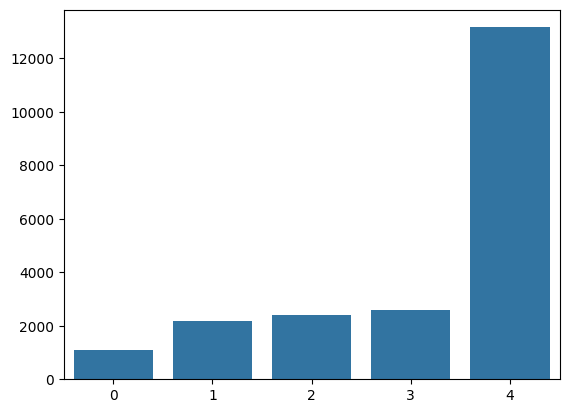

In [ ]:
from collections import Counter

# 클래스 개수 세기
class_counts = Counter(full_dataset.targets)

# 클래스 distribution을 시각화
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=0)
plt.show()

#모자이크의 편향성을 어떻게 처리할 수 있을까?

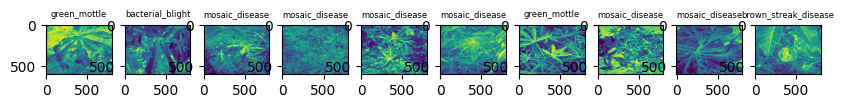

In [ ]:
import matplotlib.pyplot as plt
def image_show(dataset, num):
  fig = plt.figure(figsize = (10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i][0][0])
    plt.title(class_names[dataset[i][1]].split('___')[1], fontsize=6)


image_show(train_dataset, 10)

In [ ]:
pip install timm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

In [ ]:
pip install efficientnet_pytorch

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import models

# Assuming you have 'class_names' defined somewhere in your code
num_classes = len(class_names)

# Load MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
# Modify the classifier to match the number of classes in your problem
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)

In [ ]:
model = model.to(device)
print(model)

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.trial import TrialState

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.1)

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.8)

num_epochs = 15

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, dataloader, device):
  model.eval()
  all_preds = []
  all_labels = []


  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  precision = precision_score(all_labels, all_preds, average = 'weighted')
  recall = recall_score(all_labels, all_preds, average = 'weighted')
  f1 = f1_score(all_labels, all_preds, average = 'weighted')
  accuracy = accuracy_score(all_labels, all_preds)

  return precision, recall, f1, accuracy


In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    return precision, recall, f1, accuracy

# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 추천
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    # 새로운 모델 및 옵티마이저 생성
    model = timm.create_model('efficientnet_b4', pretrained=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # 훈련 루프
    num_epochs = 10  # 적절한 값으로 조정
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()  # 모델을 평가 모드로 설정
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)
                # Validation 손실 계산 및 저장

        # 학습률 스케줄러 업데이트
        step_lr_scheduler.step()

    # 검증 손실 반환 (최소화해야 할 값)
    return val_loss.item()  # 실제 검증 손실로 대체

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 가져오기
best_params = study.best_params
print(f"최적의 하이퍼파라미터: {best_params}")

# 최적의 하이퍼파라미터를 사용하여 최종 모델 생성
best_model = timm.create_model('efficientnet_b4', pretrained=True).to(device)
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_step_lr_scheduler = torch.optim.lr_scheduler.StepLR(best_optimizer, step_size=3, gamma=0.1)

# 학습 루프
num_epochs = 20
for epoch in range(num_epochs):
    best_model.train()
    correct_train = 0
    cnt_train = 0
    train_loss = 0

    for image, label in tqdm(train_loader):
        cnt_train += 1
        image, label = image.to(device), label.to(device)
        best_optimizer.zero_grad()

        output = best_model(image)
        _, pred = torch.max(output, 1)
        loss = criterion(output, label)

        loss.backward()
        best_optimizer.step()
        train_loss += loss.item()
        correct_train += torch.sum(pred == label.data)
        best_step_lr_scheduler.step()

    best_model.eval()
    correct_valid = 0
    cnt_valid = 0
    valid_loss = 0

    with torch.no_grad():
        for image, label in tqdm(valid_loader):
            cnt_valid += 1
            image, label = image.to(device), label.to(device)
            output = best_model(image)
            _, pred = torch.max(output, 1)
            loss = criterion(output, label)
            valid_loss += loss.item()
            correct_valid += torch.sum(pred == label.data)

    # 검증 성능 출력
    precision, recall, f1, accuracy = evaluate_model(best_model, valid_loader, device)
    print(f"검증 결과 - precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, accuracy: {accuracy:.3f}%")

# 테스트 루프 (필요에 따라 추가)
# 테스트 루프
best_model.eval()
correct_test = 0
cnt_test = 0

with torch.no_grad():
    for image, label in tqdm(test_loader):
        cnt_test += 1
        image, label = image.to(device), label.to(device)
        output = best_model(image)
        _, pred = torch.max(output, 1)
        correct_test += torch.sum(pred == label.data)

# 테스트 성능 출력
test_accuracy = correct_test.item() / len(test_loader.dataset) * 100
print(f"최적 모델의 테스트 정확도: {test_accuracy:.2f}%")


[I 2024-01-25 02:54:55,240] A new study created in memory with name: no-name-ec09e372-92fe-4543-9276-f277925e6218
<ipython-input-40-11a387e3bb61>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-40-11a387e3bb61>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d5e9315b130>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pyth

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [ ]:
# 학습

tr_loss = []
tr_acc = []
val_loss = []
val_acc = []
best_valid_loss = torch.inf

import time
start_time = time.time()
total_step = len(train_loader)
for epoch in range(num_epochs):
  model.train()
  correct_train = 0
  cnt_train = 0
  train_loss = 0
  for image, label in tqdm(train_loader):
    cnt_train += 1
    image = image.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    # 순전파 + 역전파 + 최적화

    output = model(image)
    _, pred = torch.max(output, 1)
    loss = criterion(output, label)


    loss.backward()
    optimizer.step()
    train_loss += loss.item() #* image.size(0) # image.size를 꼭 곱해야 하나? 모르겠음
    correct_train += torch.sum(pred == label.data)
    step_lr_scheduler.step()
  print("Train Loss: {:.4f} Train Acc: {:.4f}".format(train_loss/cnt_train, correct_train/(cnt_train * train_loader.batch_size)*100))
  tr_loss.append(train_loss/cnt_train)
  tr_acc.append(correct_train/(cnt_train * train_loader.batch_size)*100)

  # Validation
  model.eval()
  correct_valid = 0
  cnt_valid = 0
  valid_loss = 0

  with torch.no_grad():
    for image, label in tqdm(valid_loader):
      cnt_valid += 1
      image = image.to(device)
      label = label.to(device)
      output = model(image)
      _, pred = torch.max(output, 1)
      loss = criterion(output, label)
      valid_loss += loss.item() # * image.size(0) # image.size를 꼭 곱해야 하나? 모르겠음
      correct_valid += torch.sum(pred == label.data)

  if valid_loss / len(valid_dataset) <= best_valid_loss:
    best_valid_loss = valid_loss / len(valid_loader)
    best_epoch = epoch
    torch.save(model.state_dict(), "bbaksem.pth")

  print("Valid Loss: {:.4f} Valid Acc: {:.4f}".format(valid_loss/cnt_valid, correct_valid/(cnt_valid * valid_loader.batch_size)*100))

  precision, recall, f1, accuracy = evaluate_model(model, valid_loader, device)
  print(f"val precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, accuracy: {accuracy:.3f}%\n\n")
  val_loss.append(valid_loss/cnt_valid)
  val_acc.append(correct_valid/(cnt_valid * valid_loader.batch_size)*100)





print("Training complete")
print("Best epoch is", best_epoch +1)

  0%|          | 0/6419 [00:03<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR